In [1]:
'''
MacOS专用字体设置
MacOS 系统中使用的中文字体路径
适用于MacOS15版本
可直接复制到代码中使用
'''
import matplotlib.pyplot as plt
from matplotlib import font_manager
# 设置字体路径
font_path = '/System/Library/Fonts/STHeiti Medium.ttc'

# 加载字体
my_font = font_manager.FontProperties(fname=font_path)

# 设置为默认字体
plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [2]:
import pandas as pd

In [3]:
df = pd.read_excel('股票客户流失.xlsx')
df.head()

,账户资金（元）,最后一次交易距今时间（天）,上月交易佣金（元）,本券商使用时长（年）,是否流失
0,22686.5,297,149.25,0,0
1,190055.0,42,284.75,2,0
2,29733.5,233,269.25,0,1
3,185667.5,44,211.50,3,0
4,33648.5,213,353.50,0,1


# 查看数据分布

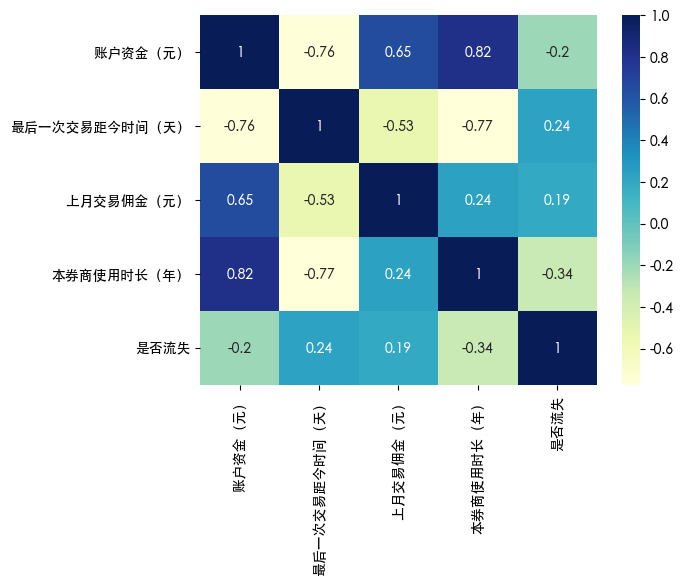

In [7]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.show()

## 直方图和QQ图

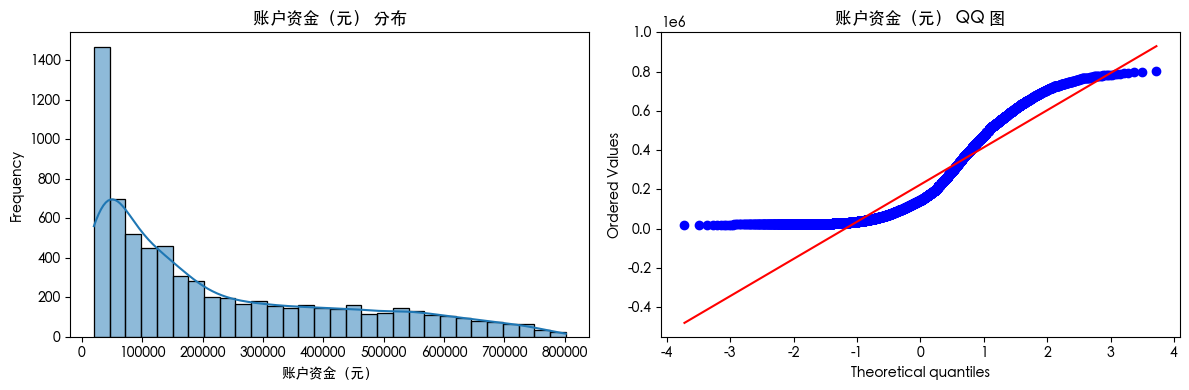

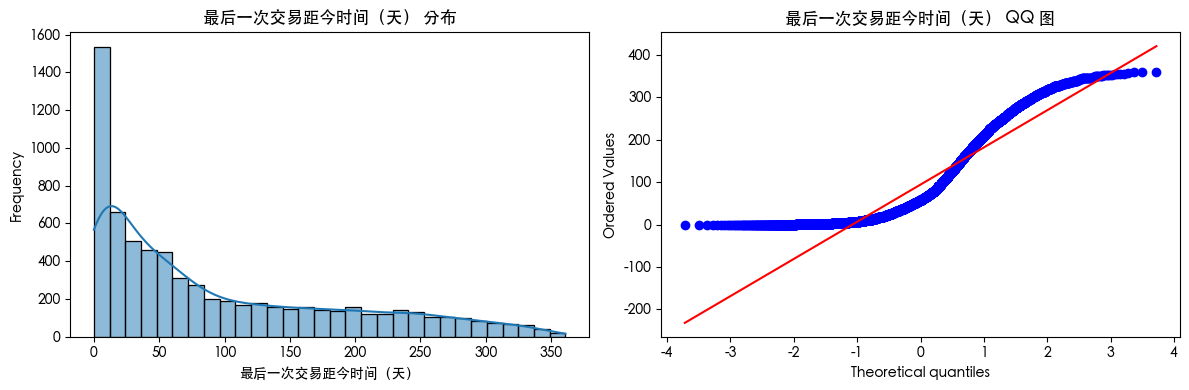

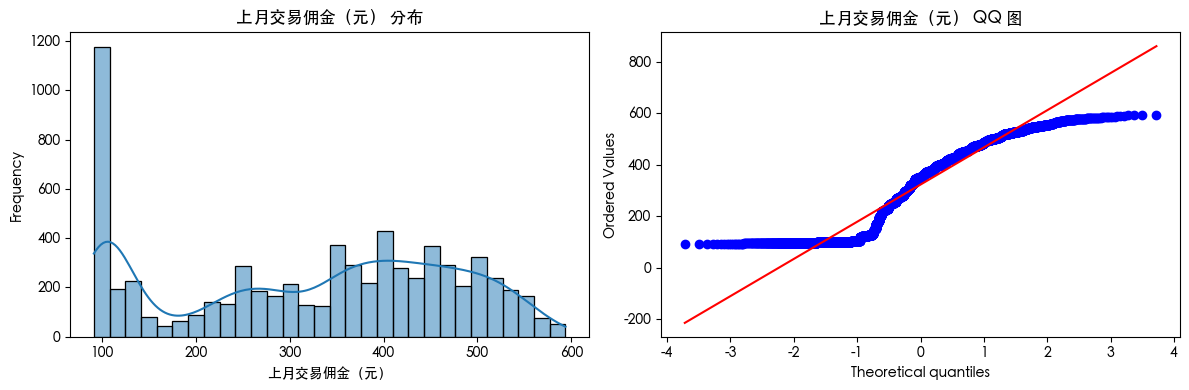

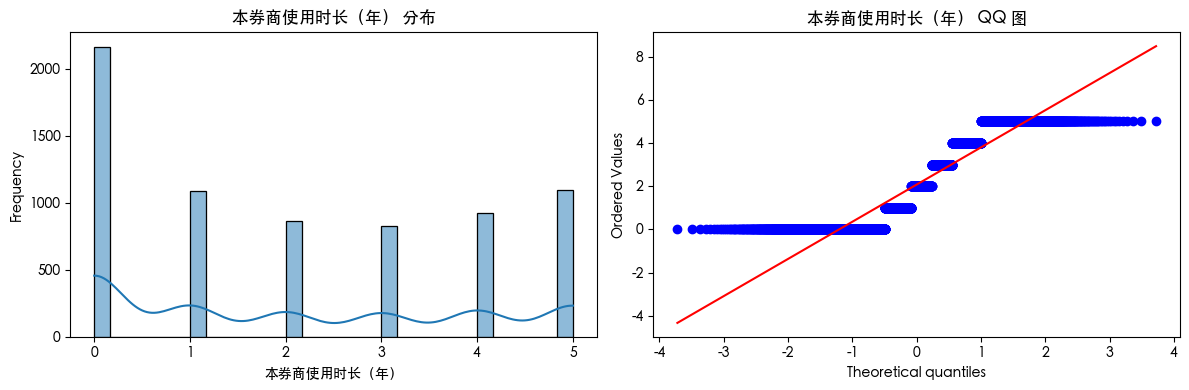

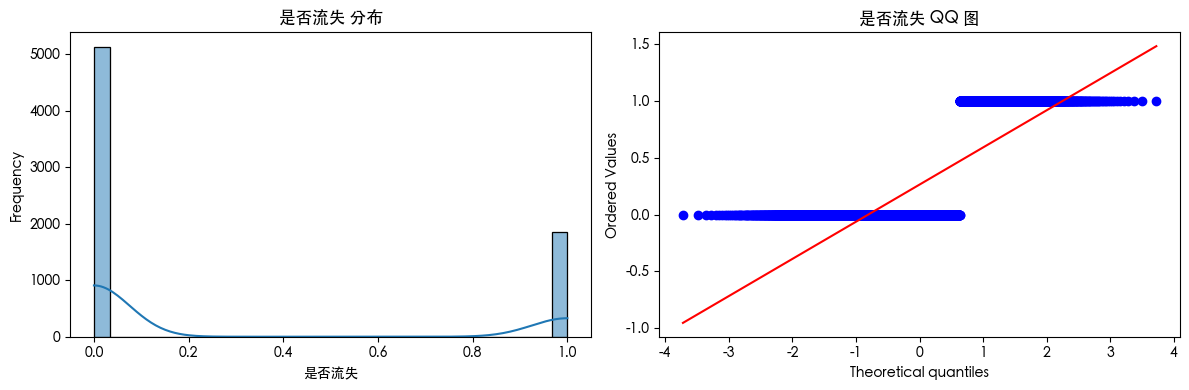

In [10]:
from scipy import stats

for col in df.columns:
    plt.figure(figsize=(12, 4))
    
    # 直方图 + KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'{col} 分布')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    # QQ图
    plt.subplot(1, 2, 2)
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f'{col} QQ 图')
    
    plt.tight_layout()
    plt.show()

# 缺失值处理

对于缺失值 我们首先查看是否有缺失值

In [ ]:
df.isnull().sum()

账户资金（元）          0
最后一次交易距今时间（天）    0
上月交易佣金（元）        0
本券商使用时长（年）       0
是否流失             0
dtype: int64

若存在缺失值 我们可以选择删除缺失值 或者填充缺失值

## 删除缺失值

In [ ]:
# 删除缺失率 > 50% 的列
df.dropna(thresh=len(df)*0.5, axis=1, inplace=True)

# 删除含缺失的行
df.dropna(inplace=True)

## 填充缺失值

In [ ]:
# 数值型 中位数或均值填充
df['age'].fillna(df['age'].median(), inplace=True) # .mean()是均值

# 类别型 众数填充
df['gender'].fillna(df['gender'].mode()[0], inplace=True)

# 固定值
df['income'].fillna(-1, inplace=True)  # -1 表示缺失

## 使用模型预测填充

In [ ]:
# KNN填充
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_filled = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 多重插补法
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state=0)
df_filled = pd.DataFrame(imp.fit_transform(df), columns=df.columns)

## 缺失值本身就是信息

In [ ]:
# 数值型缺失值标记
df['income_missing'] = df['income'].isnull().astype(int)

# 类别变量可以直接保留为NaN 或替换为 Missing
df['occupation'].fillna('Missing', inplace=True)

## 可视化缺失值

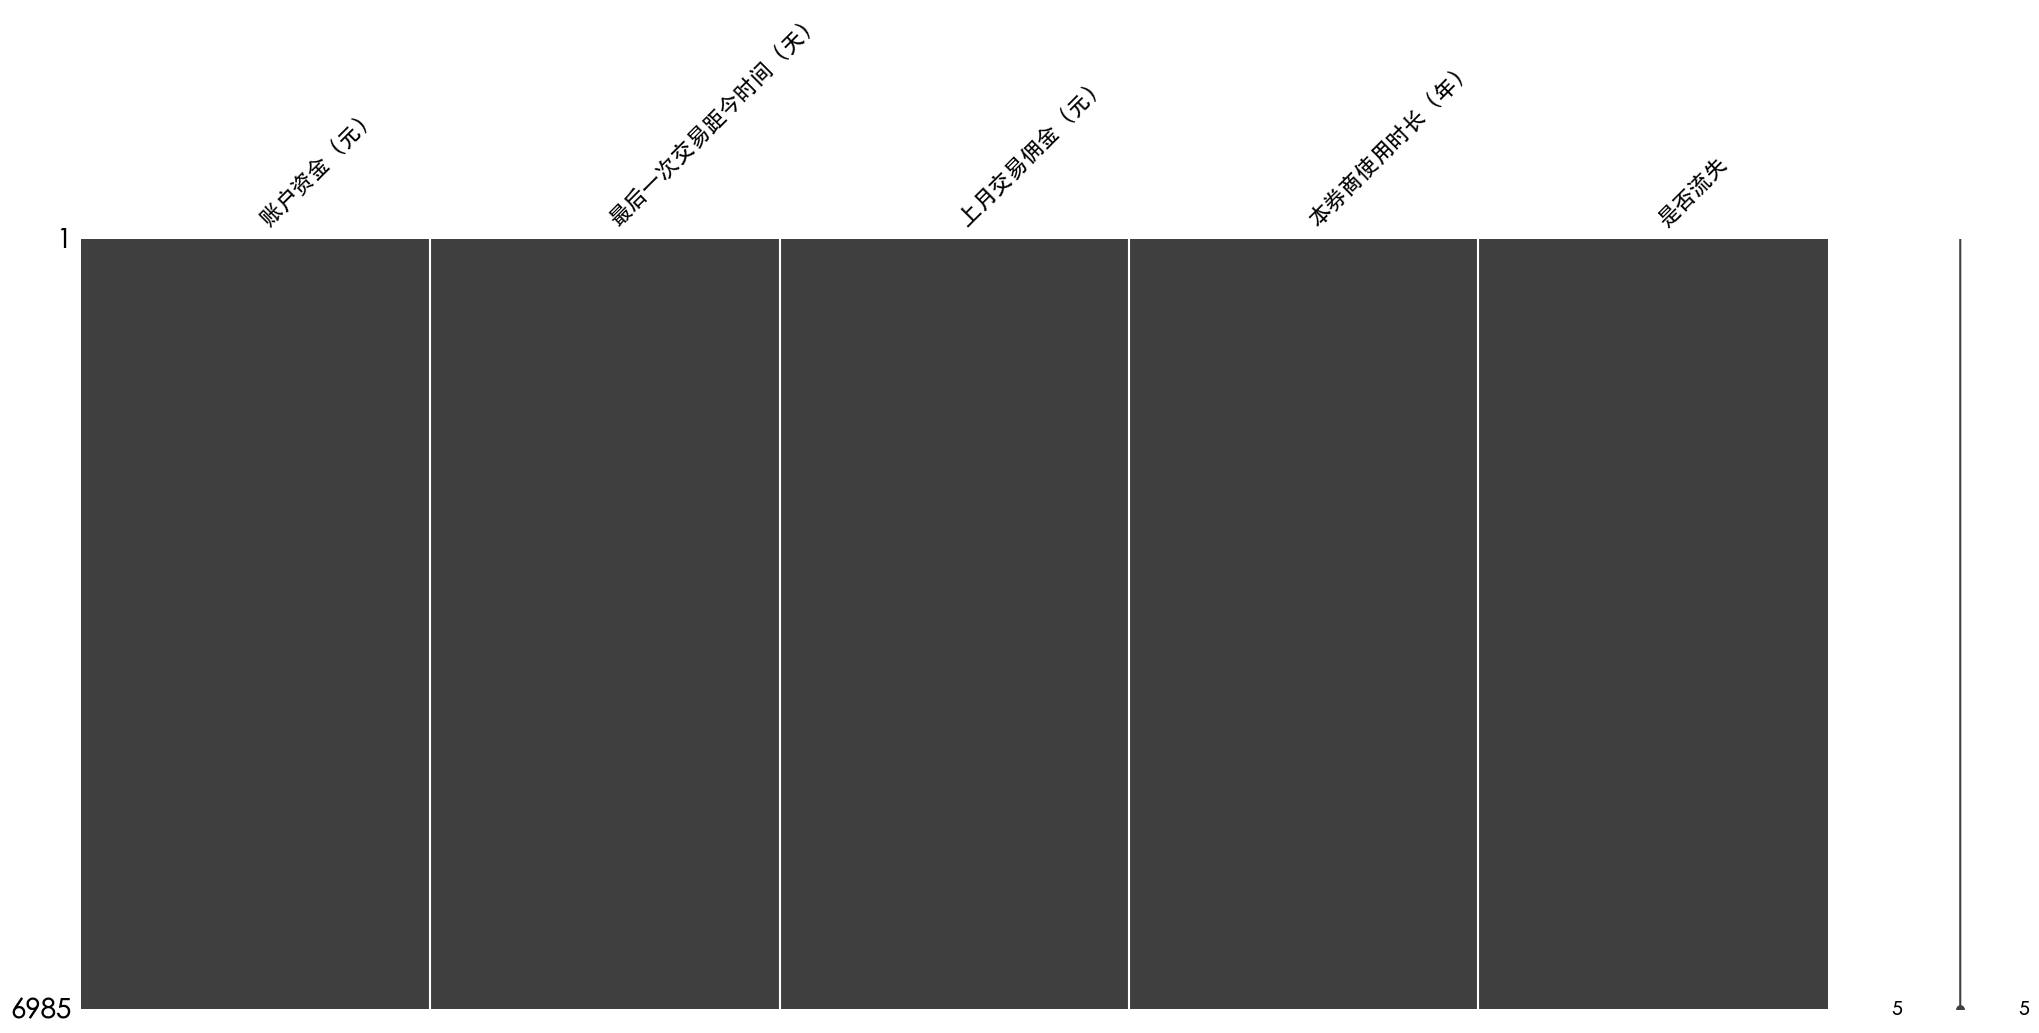

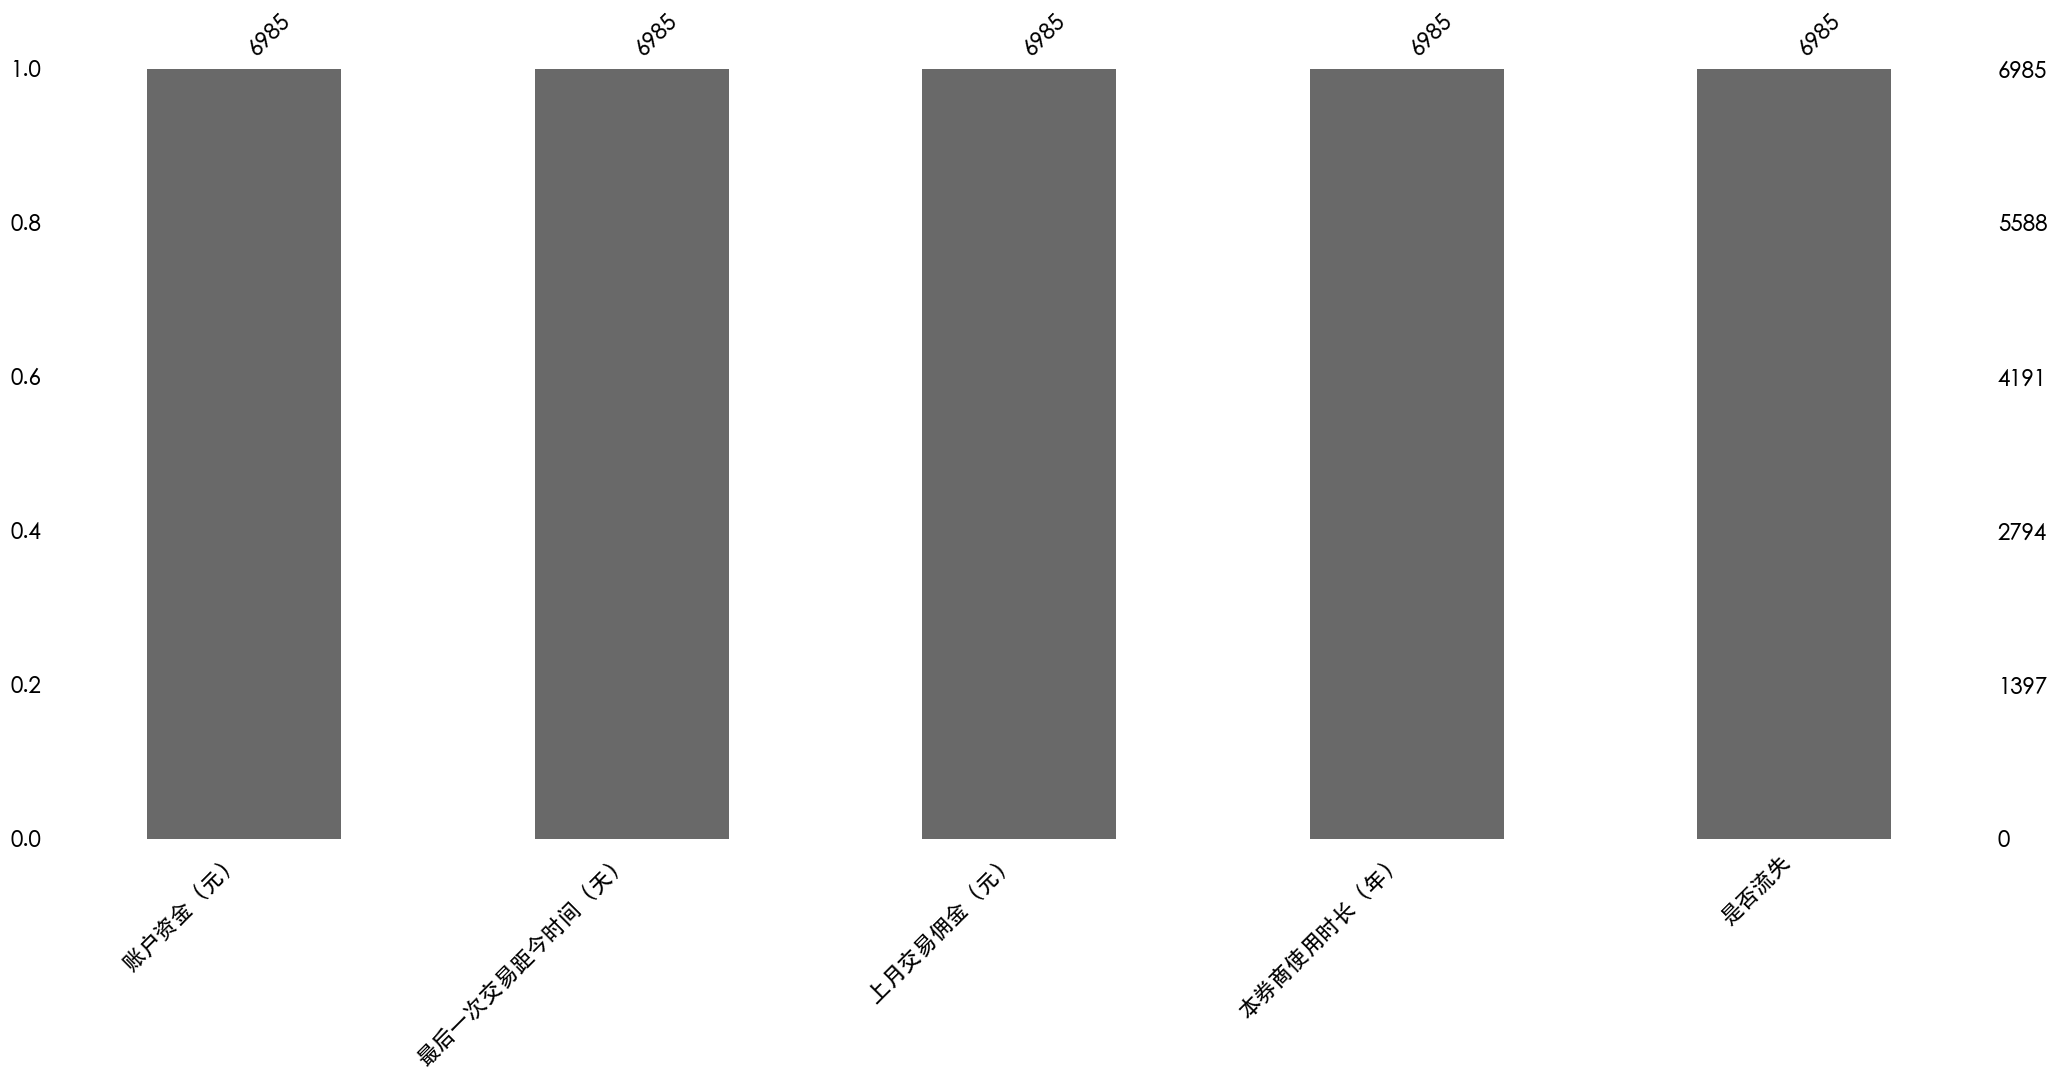

/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


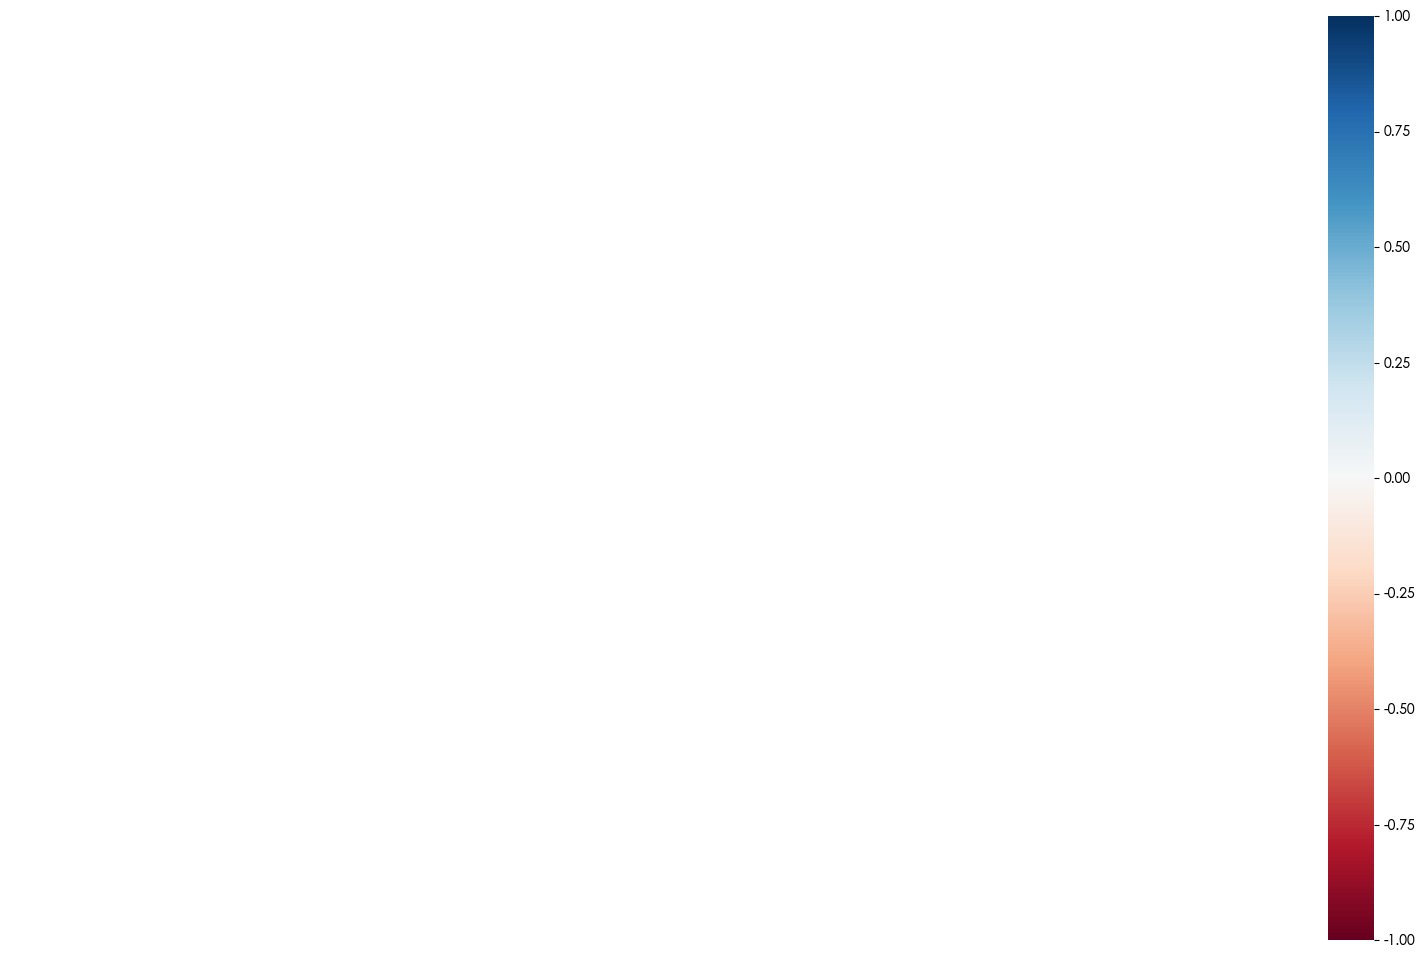

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

# 矩阵图 查看缺失位置
msno.matrix(df)
plt.show()

# 条形图 各列缺失比例
msno.bar(df)
plt.show()

# 相关性热力图 缺失是否相关
msno.heatmap(df)
plt.show()

# 异常值处理

## 用箱线图可视化异常值

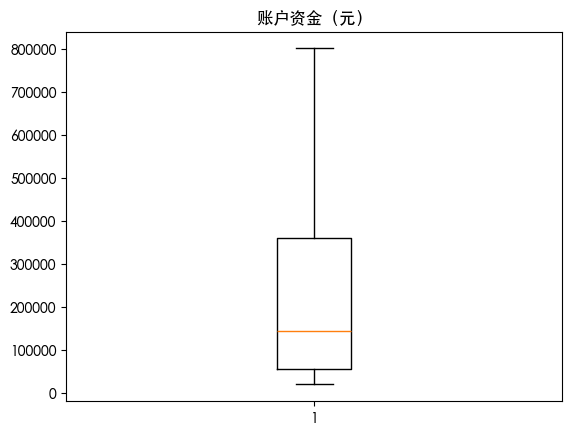

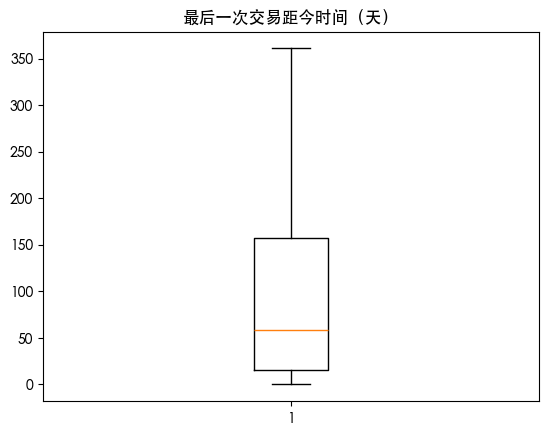

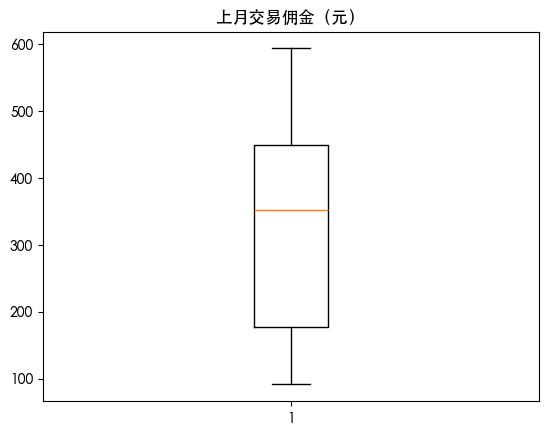

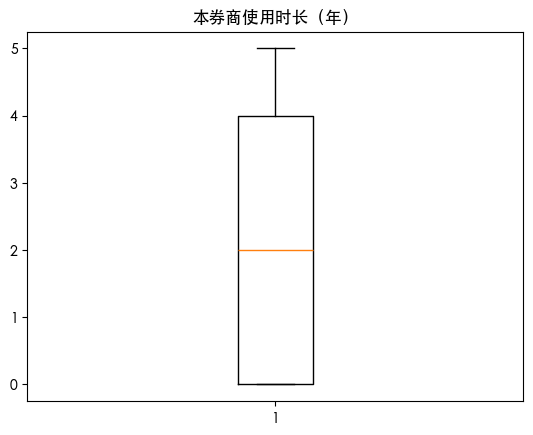

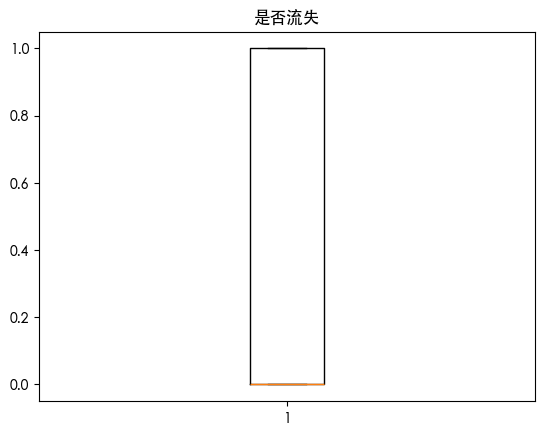

In [5]:
for col in df.columns:
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()

## 3sigma 准则 检测

In [ ]:
from scipy import stats
import numpy as np

for col in df.columns:
    z_scores = np.abs(stats.zscore(df[col].dropna()))
    outliers = df[z_scores > 3]
    print(f"列 {col} 中的异常值数量: {len(outliers)}")
    

列 账户资金（元） 中的异常值数量: 0
列 最后一次交易距今时间（天） 中的异常值数量: 0
列 上月交易佣金（元） 中的异常值数量: 0
列 本券商使用时长（年） 中的异常值数量: 0
列 是否流失 中的异常值数量: 0


# IQR 异常值检测

In [ ]:
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"列 {col} 中的异常值数量: {len(outliers)}")


列 账户资金（元） 中的异常值数量: 0
列 最后一次交易距今时间（天） 中的异常值数量: 0
列 上月交易佣金（元） 中的异常值数量: 0
列 本券商使用时长（年） 中的异常值数量: 0
列 是否流失 中的异常值数量: 0


## 百分位数法 检测

In [ ]:
for col in df.columns:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df_clipped = df[(df[col] >= lower) & (df[col] <= upper)]
    print(f"列 {col} 中的异常值数量: {len(df) - len(df_clipped)}")


列 账户资金（元） 中的异常值数量: 135
列 最后一次交易距今时间（天） 中的异常值数量: 66
列 上月交易佣金（元） 中的异常值数量: 135
列 本券商使用时长（年） 中的异常值数量: 0
列 是否流失 中的异常值数量: 0


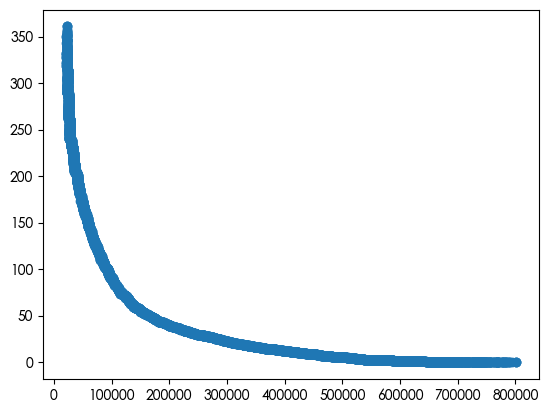

In [4]:
# 散点图 数值型变量两两关系
plt.scatter(df['账户资金（元）'], df['最后一次交易距今时间（天）'])
plt.show()

## 孤立森林 检测

In [9]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05)  # 预估异常比例5%
df['anomaly'] = iso.fit_predict(df[['账户资金（元）', '最后一次交易距今时间（天）']])
outliers = df[df['anomaly'] == -1]
print(f"检测到的异常值数量: {len(outliers)}")

检测到的异常值数量: 349


# 异常值处理

## 直接删除

In [ ]:
df = df[~outliers].copy()

## 截断

In [ ]:
def winsorize_iqr(df, col, factor=1.5):
    """用 IQR 边界截断异常值"""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[col].clip(lower=lower_bound, upper=upper_bound)

df['income_winsorized'] = winsorize_iqr(df, 'income', factor=3)  # 3倍IQR

## z-score 异常值处理

In [ ]:
def detect_outliers_zscore(df, col, threshold=3):
    """使用 Z-score 检测异常值"""
    z_scores = np.abs(stats.zscore(df[col].dropna()))
    outlier_mask = np.zeros(len(df), dtype=bool)
    outlier_mask[df[col].notna()] = z_scores > threshold
    return outlier_mask

# 数据是是接近正态的 用 Z-score 检测
z_outliers = detect_outliers_zscore(df, 'score', threshold=3)
df['score_clean'] = df['score'].where(~z_outliers, df['score'].median())  # 用中位数填充异常

## 对数变换

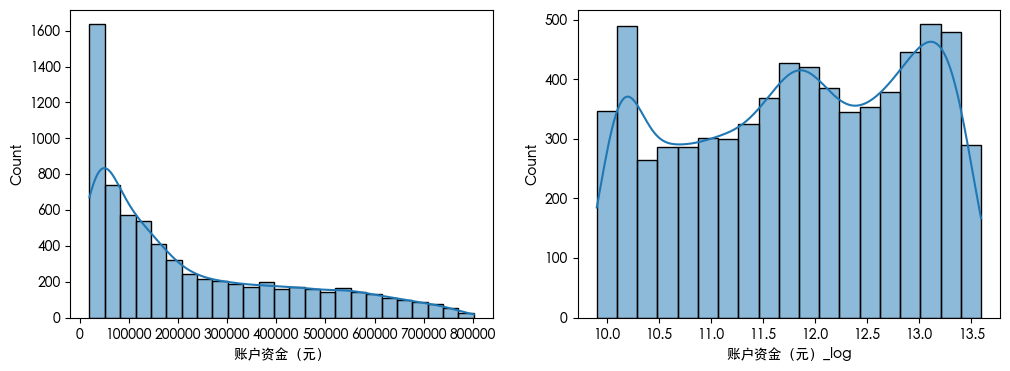

In [12]:
import numpy as np
import seaborn as sns
df['账户资金（元）_log'] = np.log1p(df['账户资金（元）'])

# 可视化对比
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['账户资金（元）'], kde=True)

plt.subplot(1, 2, 2)
sns.histplot(df['账户资金（元）_log'], kde=True)
plt.show()

## 分箱 

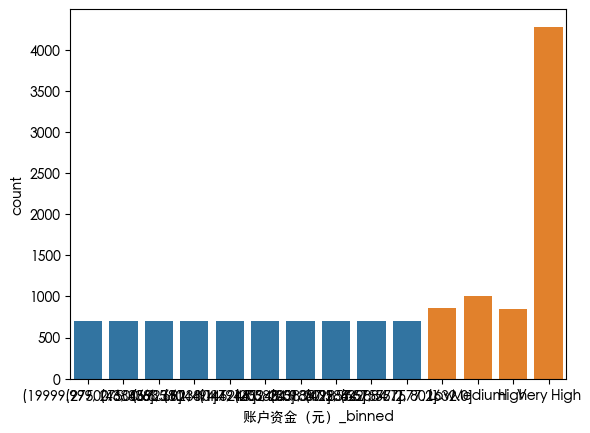

In [14]:
# 等频分箱（Quantile-based），自动处理极端值
df['账户资金（元）_binned'] = pd.qcut(df['账户资金（元）'], q=10, duplicates='drop')  # 分10箱
sns.countplot(x=df['账户资金（元）_binned'])


# 或自定义边界（把 >200000 的都归为 "High"）
bins = [0, 30000, 60000, 100000, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High']
df['账户资金（元）_group'] = pd.cut(df['账户资金（元）'], bins=bins, labels=labels, include_lowest=True)
sns.countplot(x=df['账户资金（元）_group'])
plt.show()

## 保留异常值

In [16]:
df['账户资金（元）_is_outlier'] = (df['账户资金（元）'] > 200000).astype(int)